In [30]:
import sys
sys.path.append('..')

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.cuda
import torch.utils.data as td
from torchvision.transforms import RandomRotation, RandomResizedCrop, RandomHorizontalFlip, Resize, Normalize

In [32]:
syn_mean = 106.80105799387864
syn_std = 56.62941734142311
act_mean = 0.4290619492530823
act_std = 0.14064496755599976 

In [33]:
import segmentation_models_pytorch as smp


In [34]:
from data_sets import SynData, AngioData

In [35]:
smp.__version__

'0.3.2'

In [36]:
train_val_test_split_probs = [0.5, 0.25, 0.25]
syn_data_path = r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\local_data\syn_data\syn_data"
data_path = r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\local_data\data\Data"
transformations = [
    RandomRotation(degrees=(-5, 5)), 
    RandomResizedCrop(size=(736, 736), scale=(0.7, 0.9), ratio=(0.9, 1.1)),
    RandomHorizontalFlip(p=0.5), 
    Resize(size=(736, 736))
]
syn_norm = [Normalize(mean=syn_mean, std=syn_std)]
act_norm = [Normalize(mean=act_mean, std=act_std)]

Make data set, and split

In [37]:
SynDataSet = SynData(syn_data_path + "/syn_input", syn_data_path + "/syn_label",transforms_train=syn_norm, transforms_both=transformations)
syn_train, syn_val, syn_test = td.random_split(SynDataSet, train_val_test_split_probs)


DataSet1 = AngioData(data_path + r"\ImsegmentedPt_02 V_1\Orig", data_path + r"\ImsegmentedPt_02 V_1\manual", transforms_train=act_norm, transforms_both=transformations)
DataSet4 = AngioData(data_path + r"\ImsegmentedPt_02 V_4\Orig", data_path + r"\ImsegmentedPt_02 V_4\Orig",transforms_train=act_norm, transforms_both=transformations)
DataSet6 = AngioData(data_path + r"\ImsegmentedPt_02 V_6\Orig", data_path + r"\ImsegmentedPt_02 V_6\Annotations",transforms_train=act_norm, transforms_both=transformations)
DataSet7 = AngioData(data_path + r"\ImsegmentedPt_02 V_7\Orig", data_path + r"\ImsegmentedPt_02 V_7\Annotations",transforms_train=act_norm, transforms_both=transformations)
DataSet8 = AngioData(data_path + r"\ImsegmentedPt_02 V_8\Orig", data_path + r"\ImsegmentedPt_02 V_8\Annotations",transforms_train=act_norm, transforms_both=transformations)
DataSetFull = td.ConcatDataset([DataSet1, DataSet4, DataSet6, DataSet7, DataSet8])

In [38]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
)

In [39]:
for param in model.parameters():
    param.requires_grad = False

for param in model.decoder.parameters():
    param.requires_grad = True

for param in model.encoder.layer4.parameters():
    param.requires_grad = True

In [40]:
#syn_train, syn_val, syn_test = td.Subset(syn_train, np.arange(150)),td.Subset(syn_val, np.arange(50)),td.Subset(syn_test, np.arange(50))

In [41]:
act_train, act_val, act_test = td.ConcatDataset([DataSet4, DataSet7]), AngioData(data_path + r"\ImsegmentedPt_02 V_6\Orig", data_path + r"\ImsegmentedPt_02 V_6\Annotations",transforms_train=act_norm), AngioData(data_path + r"\ImsegmentedPt_02 V_8\Orig", data_path + r"\ImsegmentedPt_02 V_8\Annotations",transforms_train=act_norm)

syn_train_loader = td.DataLoader(syn_train, batch_size=4)
syn_val_loader = td.DataLoader(syn_val)
syn_test_loader = td.DataLoader(syn_test)

act_train_loader = td.DataLoader(act_train)
act_val_loader = td.DataLoader(act_val)
act_test_loader = td.DataLoader(act_test, shuffle=True)

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)


loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10


cuda:0


In [43]:
losses = []
val_losses = []
for epoch in range(1, epochs+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(syn_train_loader)
    run_losses = []
    run_val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values, labels = batch

        #transfer data to device, e.g. GPU
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        predicted = model(pixel_values.float()) #Should not do anything bad
        
        #prob = output.sigmoid()
        #predicted = (prob > 0.5).float()
        
        #mask = (labels != 255) # we don't include the background class in the accuracy calculation
        #pred_labels = predicted.detach().cpu().numpy()
        #true_labels = labels.detach().cpu().numpy()

        #accuracy = accuracy_score(pred_labels, true_labels)
        loss = loss_fn(predicted, labels.float())
        #accuracies.append(accuracy)
        run_losses.append(loss.item())
        #pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})
        #if idx % 10 == 0:
        #    print(loss.item())
        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch2 in enumerate(syn_val_loader):
                pixel_values, labels = batch2

                #transfer data to device, e.g. GPU
                pixel_values, labels = pixel_values.to(device), labels.to(device)

                predicted = model(pixel_values.float())
    
                #prob = outputs2.sigmoid()
                #predicted = (prob > 0.5).float()

                #mask = (labels != 255) # we don't include the background class in the accuracy calculation
                #pred_labels = predicted.detach().cpu().numpy()
                #true_labels = labels.detach().cpu().numpy()
                #accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = loss_fn(predicted, labels.float())
                #val_accuracies.append(accuracy)
                run_val_losses.append(val_loss.item())
    losses.append(sum(run_losses)/len(run_losses))
    val_losses.append(sum(run_val_losses)/len(run_val_losses))
    print(f"Train Loss: {losses[epoch-1]}\
         Val Loss: {val_losses[epoch-1]}") #Tog 10 min før

Epoch: 1


100%|██████████| 250/250 [01:27<00:00,  2.85it/s]


Train Loss: 0.6982931394577027         Val Loss: 0.65872221159935
Epoch: 2


100%|██████████| 250/250 [01:28<00:00,  2.84it/s]


Train Loss: 0.6275050926208496         Val Loss: 0.6081236696243286
Epoch: 3


100%|██████████| 250/250 [01:27<00:00,  2.84it/s]


Train Loss: 0.5539019918441772         Val Loss: 0.5439482793807984
Epoch: 4


100%|██████████| 250/250 [01:28<00:00,  2.84it/s]


Train Loss: 0.48598067903518677         Val Loss: 0.4760375096797943
Epoch: 5


100%|██████████| 250/250 [01:27<00:00,  2.84it/s]


Train Loss: 0.4187322149276733         Val Loss: 0.41963649797439573
Epoch: 6


100%|██████████| 250/250 [01:28<00:00,  2.84it/s]


Train Loss: 0.3634350833892822         Val Loss: 0.3614397654533386
Epoch: 7


100%|██████████| 250/250 [01:27<00:00,  2.84it/s]


Train Loss: 0.31880387473106386         Val Loss: 0.32143039226531983
Epoch: 8


100%|██████████| 250/250 [01:27<00:00,  2.85it/s]


Train Loss: 0.2822110583782196         Val Loss: 0.28574984645843504
Epoch: 9


100%|██████████| 250/250 [01:30<00:00,  2.76it/s]


Train Loss: 0.2572932319641113         Val Loss: 0.2656830408573151
Epoch: 10


100%|██████████| 250/250 [01:29<00:00,  2.78it/s]


Train Loss: 0.23649227046966553         Val Loss: 0.2545497646331787


In [44]:
#torch.save(model.state_dict(), (r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/Unet_resnet50_synpretrain_10_epochs"))

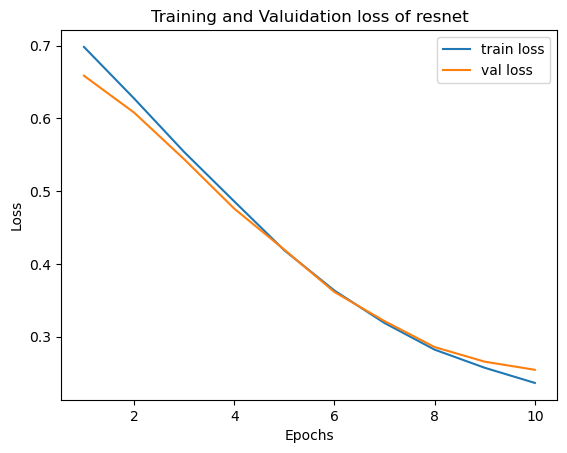

In [45]:
plt.plot(np.arange(epochs)+1, losses, '-', label="train loss")
plt.plot(np.arange(epochs)+1, val_losses, '-', label = "val loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Valuidation loss of resnet")
plt.legend()
plt.show()

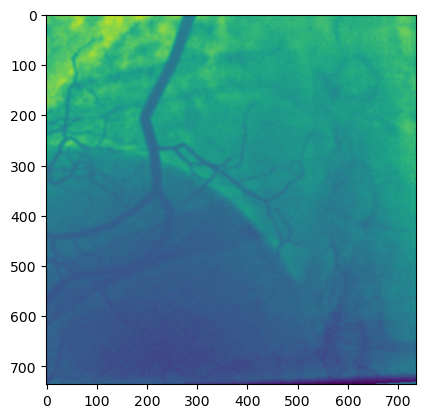

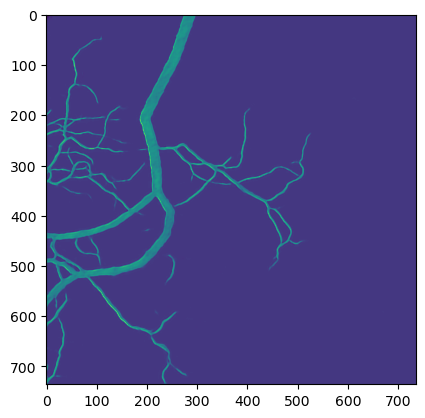

In [46]:
syn_loader = td.DataLoader(syn_test)
iter_syn = iter(syn_loader)
img, lab = next(iter_syn)
pred = model(img.to(device).float())
plt.imshow(img.numpy()[0][0])
plt.show()
#pred = pred.sigmoid()
#pred = (pred > 0.9).float()
plt.imshow(pred.detach().cpu().numpy()[0][0])

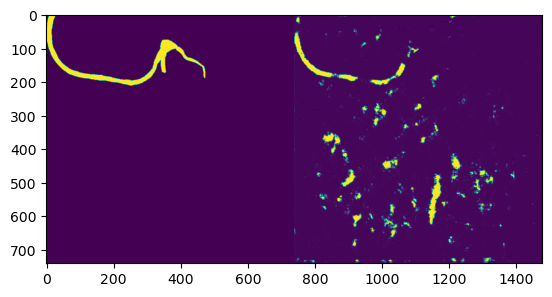

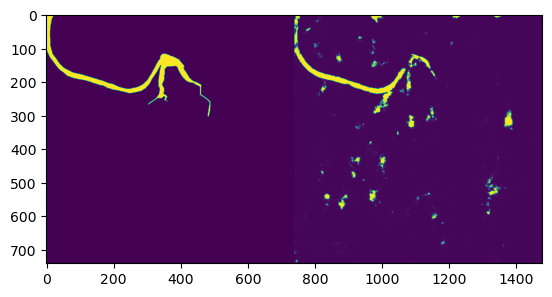

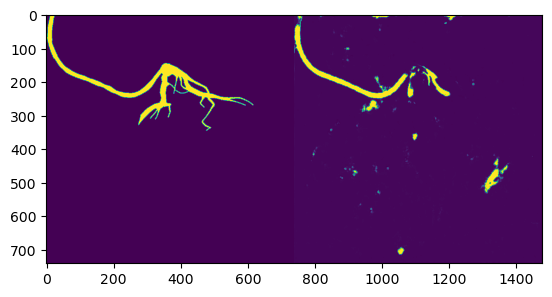

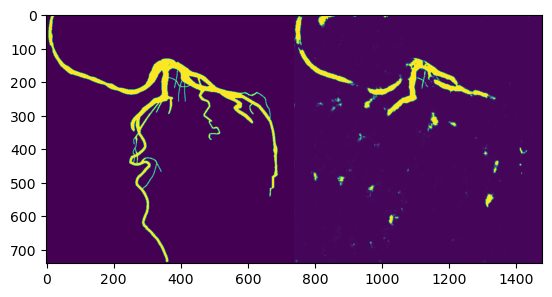

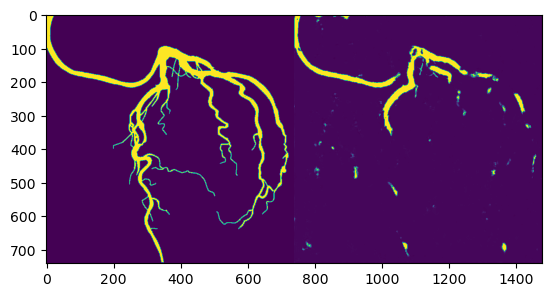

In [47]:
act_loader = td.DataLoader(act_test)
iter_act = iter(act_loader)

for i in range(5):
    img, lab = next(iter_act)
    pred = model(img.to(device).float())
    pred = pred.sigmoid()
    predlab = torch.cat((lab, pred.detach().cpu()), dim=0)
    grid = torchvision.utils.make_grid(predlab)
    plt.imshow(grid.numpy()[0])
    plt.show()

In [48]:
model2 = smp.Unet(
    encoder_name="mit_b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

In [49]:
for param in model2.parameters():
    param.requires_grad = False

for param in model2.decoder.parameters():
    param.requires_grad = True

for param in model2.encoder.block4.parameters():
    param.requires_grad = True

In [50]:
SynDataSet = SynData(syn_data_path + "/syn_input", syn_data_path + "/syn_label",transforms_train=syn_norm, transforms_both=transformations, repeat_channels=True)
syn_train, syn_val, syn_test = td.random_split(SynDataSet, train_val_test_split_probs)

act_test = AngioData(data_path + r"\ImsegmentedPt_02 V_8\Orig", data_path + r"\ImsegmentedPt_02 V_8\Annotations",transforms_train=act_norm, repeat_channels=True)
#syn_train, syn_val, syn_test = td.Subset(syn_train, np.arange(150)),td.Subset(syn_val, np.arange(50)),td.Subset(syn_test, np.arange(50))


syn_train_loader = td.DataLoader(syn_train, batch_size=4)
syn_val_loader = td.DataLoader(syn_val)
syn_test_loader = td.DataLoader(syn_test)


act_val_loader = td.DataLoader(act_val)

In [51]:
model2.to(device)

loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
epochs = 10

In [52]:
losses = []
val_losses = []
for epoch in range(1, epochs+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(syn_train_loader)
    run_losses = []#0.0
    run_val_losses = []#0.0
    model2.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values, labels = batch

        #transfer data to device, e.g. GPU
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        predicted = model2(pixel_values.float()) #Should not do anything bad
        
        #prob = output.sigmoid()
        #predicted = (prob > 0.5).float()
        
        #mask = (labels != 255) # we don't include the background class in the accuracy calculation
        #pred_labels = predicted.detach().cpu().numpy()
        #true_labels = labels.detach().cpu().numpy()

        #accuracy = accuracy_score(pred_labels, true_labels)
        loss = loss_fn(predicted, labels.float())
        #accuracies.append(accuracy)
        run_losses.append(loss.item())
        #pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})
        
        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model2.eval()
        with torch.no_grad():
            for idx, batch2 in enumerate(syn_val_loader):
                pixel_values, labels = batch2

                #transfer data to device, e.g. GPU
                pixel_values, labels = pixel_values.to(device), labels.to(device)

                predicted = model2(pixel_values.float())
    
                #prob = outputs2.sigmoid()
                #predicted = (prob > 0.5).float()

                #mask = (labels != 255) # we don't include the background class in the accuracy calculation
                #pred_labels = predicted.detach().cpu().numpy()
                #true_labels = labels.detach().cpu().numpy()
                #accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = loss_fn(predicted, labels.float())
                #val_accuracies.append(accuracy)
                run_val_losses.append(val_loss.item())
    losses.append(sum(run_losses)/len(run_losses))
    val_losses.append(sum(run_val_losses)/len(run_val_losses))
    print(f"Train Loss: {losses[epoch-1]}\
         Val Loss: {val_losses[epoch-1]}") #Tog 10 min før

Epoch: 1


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


Train Loss: 0.6245964889526368         Val Loss: 0.5808447751998901
Epoch: 2


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


Train Loss: 0.48416850876808165         Val Loss: 0.4497274324893951
Epoch: 3


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


Train Loss: 0.37351862359046933         Val Loss: 0.3460326957702637
Epoch: 4


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


Train Loss: 0.2993270843029022         Val Loss: 0.2872867228984833
Epoch: 5


100%|██████████| 250/250 [01:53<00:00,  2.21it/s]


Train Loss: 0.24915747499465943         Val Loss: 0.24007783079147338
Epoch: 6


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


Train Loss: 0.22049959301948546         Val Loss: 0.2170305917263031
Epoch: 7


100%|██████████| 250/250 [01:53<00:00,  2.21it/s]


Train Loss: 0.20007055020332337         Val Loss: 0.19781163239479066
Epoch: 8


100%|██████████| 250/250 [01:53<00:00,  2.21it/s]


Train Loss: 0.18618211102485657         Val Loss: 0.1884149498939514
Epoch: 9


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


Train Loss: 0.17712310218811037         Val Loss: 0.18742463445663451
Epoch: 10


100%|██████████| 250/250 [01:53<00:00,  2.20it/s]


Train Loss: 0.16912068271636962         Val Loss: 0.16881889271736145


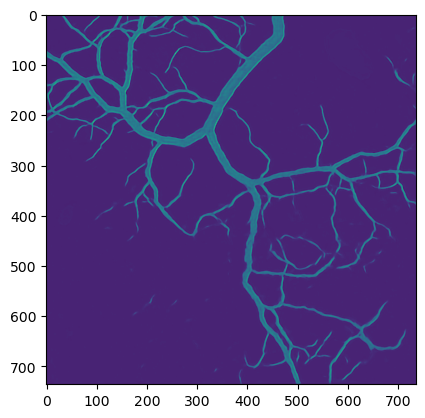

In [53]:
plt.imshow(predicted.detach().cpu().numpy()[0][0])

In [54]:
#torch.save(model2.state_dict(), (r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/Unet_mit-b3_synpretrain_10_epochs"))

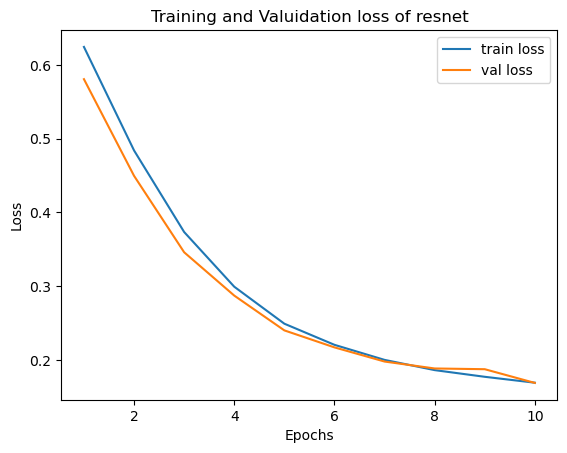

In [55]:
plt.plot(np.arange(epochs)+1, losses, '-', label="train loss")
plt.plot(np.arange(epochs)+1, val_losses, '-', label = "val loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Valuidation loss of resnet")
plt.legend()
plt.show()

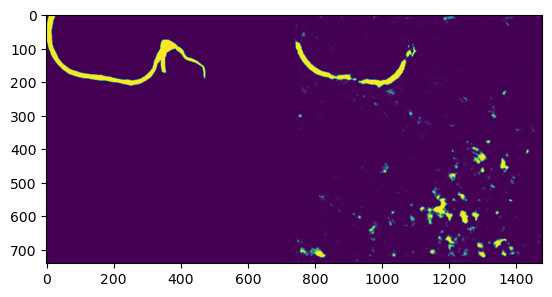

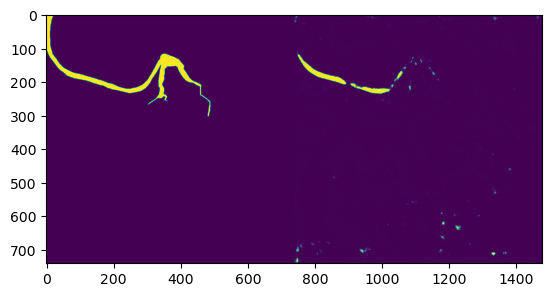

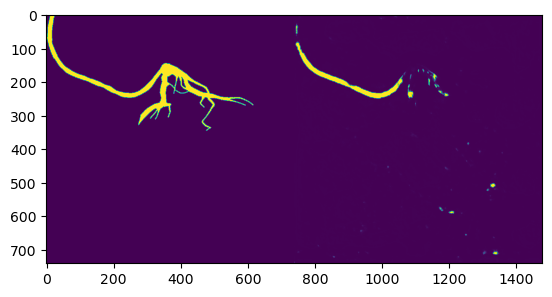

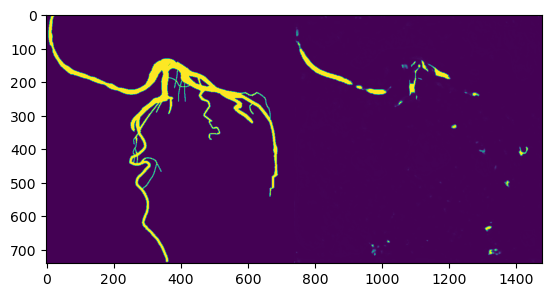

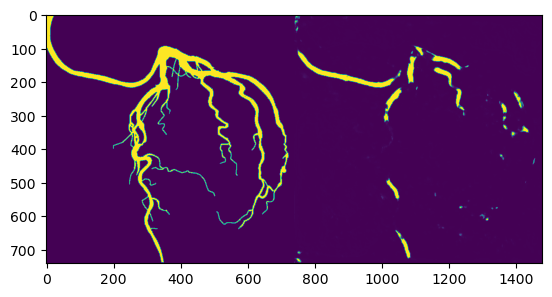

In [59]:
act_loader = td.DataLoader(act_test)
iter_act = iter(act_loader)

for i in range(5):
    img, lab = next(iter_act)
    pred = model2(img.to(device).float())
    pred = pred.sigmoid()
    predlab = torch.cat((lab, pred.detach().cpu()), dim=0)
    grid = torchvision.utils.make_grid(predlab)
    plt.imshow(grid.numpy()[0])
    plt.show()

In [57]:
#from torch.utils.data import DataLoader
#
#batch_size = 2
#
#syn_loader = DataLoader(
#  SynDataSet, 
#  batch_size = batch_size, 
#  num_workers=1)
#
#act_loader = DataLoader(
#  DataSetFull, 
#  batch_size = 1
#  )
#
#def batch_mean_and_sd(loader):
#    
#    cnt = 0
#    fst_moment = torch.empty(3)
#    snd_moment = torch.empty(3)
#
#    for images, _ in loader:
#        b, c, h, w = images.shape
#        nb_pixels = b * h * w
#        sum_ = torch.sum(images, dim=[0, 2, 3])
#        sum_of_square = torch.sum(images ** 2,
#                                  dim=[0, 2, 3])
#        fst_moment = (cnt * fst_moment + sum_) / (
#                      cnt + nb_pixels)
#        snd_moment = (cnt * snd_moment + sum_of_square) / (
#                            cnt + nb_pixels)
#        cnt += nb_pixels
#
#    mean, std = fst_moment, torch.sqrt(
#      snd_moment - fst_moment ** 2)        
#    return mean,std
#  
#syn_mean, syn_std = batch_mean_and_sd(syn_loader)
#print("mean and std {0}, {1}: \n".format(syn_mean.numpy()[0], syn_std.numpy()[0]))
#
#act_mean, act_std = batch_mean_and_sd(act_loader)
#print("mean and std: {0}, {1} \n".format(act_mean.numpy()[0], act_std.numpy()[0]))
#